### Spark notebook ###

This notebook will only work in a Jupyter session running on `mathmadslinux2p`.

You can start your own Jupyter session on `mathmadslinux2p` and open this notebook in Chrome on the MADS Windows server by

**Steps**

1. Login to the MADS Windows server using https://mathportal.canterbury.ac.nz/.
2. Download or copy this notebook to your home directory.
3. Open powershell and run `ssh mathmadslinux2p`.
4. Run `start_pyspark_notebook` or `/opt/anaconda3/bin/jupyter-notebook --ip 132.181.129.68 --port $((8000 + $((RANDOM % 999))))`.
5. Copy / paste the url provided in the shell window into Chrome on the MADS Windows server.
6. Open the notebook from the Jupyter root directory (which is your home directory).
7. Run `start_spark()` to start a spark session in the notebook.
8. Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the Spark UI.

In [7]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [8]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=4)

spark.app.name,kda115 (jupyter)
spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.ui.port,4692
spark.driver.memory,4g
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.app.startTime,1726369396655
spark.executor.cores,2
spark.driver.host,mathmadslinux2p.canterbury.ac.nz


In [9]:
# Import the pyspark API to defined data types
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import Row

In [10]:
# Reload the daily schema 
schema_daily = StructType([
    StructField("Station_ID", StringType(), True),
    StructField("DATE",  StringType(), True),
    StructField("Element", StringType(), True),
    StructField("VALUE", IntegerType(), True),
    StructField("Measurement_Flag", StringType(), True),
    StructField("Quality_Flag", StringType(), True),
    StructField("Source_Flag", StringType(), True),
    StructField("Observation_Time", StringType(), True)
])

In [11]:
# Read the daily data from HDFS
daily_data = (spark.read.format('csv').
         option('header', False).
         option('inferSchema', False).
         schema(schema_daily).
         load('hdfs:///data/ghcnd/daily')) 

# Show the result
daily_data.printSchema()
show_as_html(daily_data, 10)

root
 |-- Station_ID: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- Element: string (nullable = true)
 |-- VALUE: integer (nullable = true)
 |-- Measurement_Flag: string (nullable = true)
 |-- Quality_Flag: string (nullable = true)
 |-- Source_Flag: string (nullable = true)
 |-- Observation_Time: string (nullable = true)



,Station_ID,DATE,Element,VALUE,Measurement_Flag,Quality_Flag,Source_Flag,Observation_Time
0,AE000041196,20100101,TMAX,259,None,None,S,None
1,AE000041196,20100101,TMIN,120,None,None,S,None
2,AE000041196,20100101,TAVG,181,H,None,S,None
3,AEM00041194,20100101,TMAX,250,None,None,S,None
4,AEM00041194,20100101,TMIN,168,None,None,S,None
5,AEM00041194,20100101,PRCP,0,None,None,S,None
6,AEM00041194,20100101,TAVG,194,H,None,S,None
7,AEM00041217,20100101,TMAX,250,None,None,S,None
8,AEM00041217,20100101,TMIN,146,None,None,S,None
9,AEM00041217,20100101,TAVG,199,H,None,S,None


### Question 02:  Calculate the  average rainfall each country 

#### A.1 Group the precipitation observations by year and by country. Compute the average rainfall in each year for each country

In [6]:
# Filter for precipitation (PRCP) observations
prcp_data = daily_data.filter(F.col("Element") == "PRCP")

# Show the result 
show_as_html(prcp_data, 5)

,Station_ID,DATE,Element,VALUE,Measurement_Flag,Quality_Flag,Source_Flag,Observation_Time
0,AEM00041194,20100101,PRCP,0,None,None,S,NaT
1,AG000060390,20100101,PRCP,0,None,None,S,NaT
2,AG000060590,20100101,PRCP,0,None,None,S,NaT
3,AG000060611,20100101,PRCP,0,None,None,S,NaT
4,AGE00147708,20100101,PRCP,5,None,None,S,NaT


In [7]:
# Extract the year from the DATE column and the country code from the Station_ID
prcp_data = (prcp_data.filter(F.col("VALUE") >= 0).
            withColumn('Year', F.substring(F.col('Date'), 1, 4).cast('integer')).
            withColumn("Country_Code", F.substring(F.col("Station_ID"), 1, 2)))


# Show the result 
show_as_html(prcp_data, 5)

,Station_ID,DATE,Element,VALUE,Measurement_Flag,Quality_Flag,Source_Flag,Observation_Time,Year,Country_Code
0,AEM00041194,20100101,PRCP,0,None,None,S,NaT,2010,AE
1,AG000060390,20100101,PRCP,0,None,None,S,NaT,2010,AG
2,AG000060590,20100101,PRCP,0,None,None,S,NaT,2010,AG
3,AG000060611,20100101,PRCP,0,None,None,S,NaT,2010,AG
4,AGE00147708,20100101,PRCP,5,None,None,S,NaT,2010,AG


In [8]:
# Group by Station_ID and Year and count the number of records for each combination
record_count_per_station_year = prcp_data.groupBy("Station_ID", "Year").count()

# Filter to find years with fewer than 365 or 366 records
incomplete_records = record_count_per_station_year.filter((record_count_per_station_year["count"] < 365) | (record_count_per_station_year["count"] > 366))

# Show the result of incomplete records
show_as_html(incomplete_records)

,Station_ID,Year,count
0,AGM00060607,2011,356
1,ARM00087046,2011,128
2,ASM00094299,2011,340
3,ASN00001028,2011,151
4,ASN00002022,2011,243
5,ASN00006045,2011,314
6,ASN00006084,2011,364
7,ASN00008025,2011,341
8,ASN00009192,2011,314
9,ASN00009592,2011,361


In [8]:
# Group by Year and Country and compute the average rainfall
country_prcp = (prcp_data.groupBy("Year", "Country_Code")
                                         .agg(F.avg("VALUE").alias("Average_Rainfall")))
    
# Show the result
show_as_html(country_prcp, 5)

,Year,Country_Code,Average_Rainfall
0,2010,FM,86.549397
1,2010,HR,38.181053
2,2010,ID,182.684366
3,2022,IS,10.770124
4,2022,LH,28.788981


#### A.2 Generate descriptive statistics for the average rainfall 

In [10]:
# Generate descriptive statistics for the average rainfall
show_as_html(country_prcp.describe('Average_Rainfall'))

,summary,Average_Rainfall
0,count,17548
1,mean,41.82306515590738
2,stddev,84.49145440556156
3,min,0.0
4,max,4361.0


#### A.3 Which country has the highest average rainfall in a single year across the entire dataset?

In [9]:
# Load the countries dataset from HDFS
countries_raw = spark.read.text("hdfs:///data/ghcnd/ghcnd-countries.txt")

# Transform unstructured 'ghcnd_countries' string into separate string columns
countries = countries_raw.select(
    F.trim(F.substring(countries_raw.value, 1, 2)).alias("Country_Code"),
    F.trim(F.substring(countries_raw.value, 4, 61)).alias("Country_Name")
)

# show the result 
show_as_html(countries, 5)

,Country_Code,Country_Name
0,AC,Antigua and Barbuda
1,AE,United Arab Emirates
2,AF,Afghanistan
3,AG,Algeria
4,AJ,Azerbaijan


In [10]:
# Join the prcp_data with countries table to get the country_name for each country.
country_prcp_data = country_prcp.join(F.broadcast(countries), "Country_Code", how="inner")

# show the result in descending order 
show_as_html(country_prcp_data.sort(F.col("Average_Rainfall"),ascending = False), 5)

,Country_Code,Year,Average_Rainfall,Country_Name
0,EK,2000,4361.000000,Equatorial Guinea
1,DR,1975,3414.000000,Dominican Republic
2,LA,1974,2480.500000,Laos
3,BH,1978,2244.714286,Belize
4,NN,1979,1967.000000,Sint Maarten


### Look further to the highest rainfall countries

In [11]:
# Filter the data where the Country_Code is 'LA'
highest_rainfall_country = prcp_data.filter(prcp_data["Country_Code"] == "EK")

# Show the result
show_as_html(highest_rainfall_country, 5)

,Station_ID,DATE,Element,VALUE,Measurement_Flag,Quality_Flag,Source_Flag,Observation_Time,Year,Country_Code
0,EKM00064810,20100725,PRCP,71,None,None,S,NaT,2010,EK
1,EKM00064810,20100726,PRCP,201,None,None,S,NaT,2010,EK
2,EKM00064810,20100727,PRCP,10,None,None,S,NaT,2010,EK
3,EKM00064810,20100728,PRCP,0,None,None,S,NaT,2010,EK
4,EKM00064810,20110305,PRCP,10,None,None,S,NaT,2011,EK


In [16]:
# Filter the data for station EKM00064810
station_data = highest_rainfall_country.filter(highest_rainfall_country["Station_ID"] == "EKM00064810")

# Group by Year and collect all the values for each year
yearly_values = station_data.groupBy("Year").agg(F.collect_list("VALUE").alias("Values")).orderBy("Year")

# Show the result
show_as_html(yearly_values)

,Year,Values
0,1996,"[140, 701, 10, 681, 0, 41, 2550, 521, 541]"
1,1997,"[2350, 0, 41, 950, 0, 480, 1471, 551, 820, 0, ..."
2,2000,[4361]
3,2001,[1100]
4,2010,"[71, 201, 10, 0]"
5,2011,"[10, 79, 0, 20, 30, 30, 0, 71, 0, 99, 0, 221, ..."
6,2012,"[660, 0, 150, 10, 30, 419, 5, 191, 10, 0, 51, ..."
7,2013,"[0, 89, 0, 119, 0, 20, 51, 0]"
8,2014,"[0, 0, 3, 0, 0, 361, 0, 150, 0, 490, 0, 89, 20..."
9,2015,"[20, 0, 10, 20, 0, 150, 0, 10, 10, 0, 30, 30, ..."


The country have the highest average rainfall is Equatorial Guinea which indicate 4361 in 2000 across the entire dataset.

#### 1. Equatorial Guinea 

In [12]:
# Look at Equatorial Guinea (Country Code 'EK') yearly rainfall
equatorial_guinea_data = country_prcp_data.filter(country_prcp_data["Country_Code"] == "EK")

# Display the result
show_as_html(equatorial_guinea_data)

,Country_Code,Year,Average_Rainfall,Country_Name
0,EK,2012,89.618421,Equatorial Guinea
1,EK,2021,83.189542,Equatorial Guinea
2,EK,2018,90.000000,Equatorial Guinea
3,EK,2019,62.307692,Equatorial Guinea
4,EK,1997,709.363636,Equatorial Guinea
5,EK,2015,83.449275,Equatorial Guinea
6,EK,2023,76.488806,Equatorial Guinea
7,EK,2016,124.853535,Equatorial Guinea
8,EK,2013,89.270270,Equatorial Guinea
9,EK,2014,58.421053,Equatorial Guinea


In [13]:
# Convert the PySpark DataFrame to a Pandas DataFrame
equatorial_guinea_pandas = equatorial_guinea_data.toPandas()

#### 2. Laos 

In [14]:
# Look at Laos yearly rainfall
laos_data = country_prcp_data.filter(country_prcp_data["Country_Code"] == "LA")

# Display the result
show_as_html(laos_data)

,Country_Code,Year,Average_Rainfall,Country_Name
0,LA,2005,82.811224,Laos
1,LA,1966,68.918259,Laos
2,LA,1993,27.500000,Laos
3,LA,2022,109.283174,Laos
4,LA,1968,39.412109,Laos
5,LA,1982,70.052632,Laos
6,LA,1959,184.357143,Laos
7,LA,1983,65.070588,Laos
8,LA,1989,50.142857,Laos
9,LA,2008,114.573991,Laos


In [15]:
# Convert the PySpark DataFrame to a Pandas DataFrame
laos_data_pandas = laos_data.toPandas()

#### 3. Domanica Republic

In [16]:
# Look at Domanican  yearly rainfall
domanican_data = country_prcp_data.filter(country_prcp_data["Country_Code"] == "DR")

# Display the result
show_as_html(domanican_data) 

,Country_Code,Year,Average_Rainfall,Country_Name
0,DR,2009,58.572727,Dominican Republic
1,DR,2007,78.805556,Dominican Republic
2,DR,2000,54.360795,Dominican Republic
3,DR,1997,38.981758,Dominican Republic
4,DR,1998,54.152603,Dominican Republic
5,DR,1974,579.000000,Dominican Republic
6,DR,2016,79.172507,Dominican Republic
7,DR,1991,68.242857,Dominican Republic
8,DR,1984,44.044601,Dominican Republic
9,DR,1966,34.955466,Dominican Republic


In [17]:
# Convert the PySpark DataFrame to a Pandas DataFrame
domanican_data_pandas = domanican_data.toPandas()

### Plot the distribution of the highest average rainfall countries

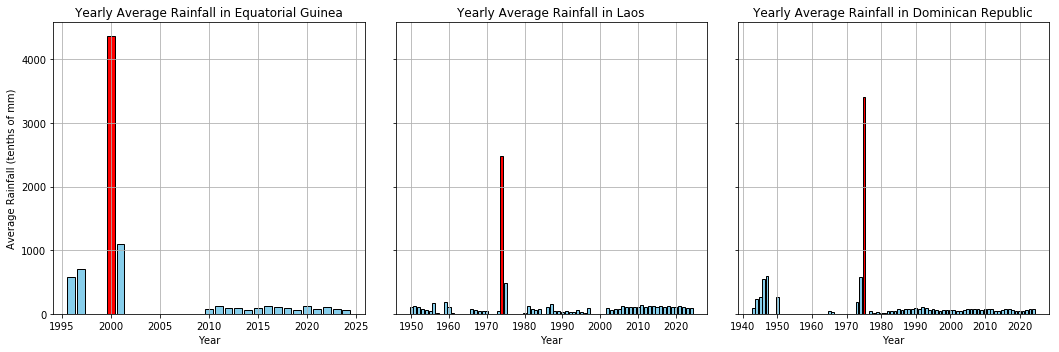

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting bar plots for the three countries
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Equatorial Guinea Bar Plot
eq_guinea_years = equatorial_guinea_pandas['Year']
eq_guinea_rainfall = equatorial_guinea_pandas['Average_Rainfall']
eq_max_index = eq_guinea_rainfall.idxmax()  # Find the index of the max value
eq_colors = ['red' if i == eq_max_index else 'skyblue' for i in eq_guinea_rainfall.index]  # Color the max bar red

axes[0].bar(eq_guinea_years, eq_guinea_rainfall, color=eq_colors, edgecolor='black')
axes[0].set_title('Yearly Average Rainfall in Equatorial Guinea')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Average Rainfall (tenths of mm)')
axes[0].grid(True)

# Laos Bar Plot
laos_years = laos_data_pandas['Year']
laos_rainfall = laos_data_pandas['Average_Rainfall']
laos_max_index = laos_rainfall.idxmax()  # Find the index of the max value
laos_colors = ['red' if i == laos_max_index else 'skyblue' for i in laos_rainfall.index]  # Color the max bar red

axes[1].bar(laos_years, laos_rainfall, color=laos_colors, edgecolor='black')
axes[1].set_title('Yearly Average Rainfall in Laos')
axes[1].set_xlabel('Year')
axes[1].grid(True)

# Dominican Republic Bar Plot
dom_years = domanican_data_pandas['Year']
dom_rainfall = domanican_data_pandas['Average_Rainfall']
dom_max_index = dom_rainfall.idxmax()  # Find the index of the max value
dom_colors = ['red' if i == dom_max_index else 'skyblue' for i in dom_rainfall.index]  # Color the max bar red

axes[2].bar(dom_years, dom_rainfall, color=dom_colors, edgecolor='black')
axes[2].set_title('Yearly Average Rainfall in Dominican Republic')
axes[2].set_xlabel('Year')
axes[2].grid(True)

plt.tight_layout()
#plt.savefig('High_Rainfall_Histogram.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()